In [1]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

     |████████████████████████████████| 3.1 MB 10.9 MB/s 
     |████████████████████████████████| 895 kB 35.1 MB/s 
     |████████████████████████████████| 3.3 MB 39.6 MB/s 
     |████████████████████████████████| 59 kB 6.9 MB/s 
     |████████████████████████████████| 596 kB 44.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import warnings
warnings.filterwarnings("ignore")
!pip install --upgrade beautifulsoup4
from google.colab import drive
import time 
import itertools

from IPython.display import clear_output

import gc
import re
import json
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

from typing import List

from sklearn.svm import SVC
from sklearn import pipeline as pip
from sklearn.metrics import make_scorer
from sklearn.feature_extraction import text as txt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier 



     |████████████████████████████████| 97 kB 4.4 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [3]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla K80


In [4]:
# set environment as googledrive to folder "resource"
data_path =  "/Doğuş Datathon/"

try:
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/Doğuş Datathon/"

except:
    print("You are not working in Colab at the moment :(")

Mounted at /content/drive


In [5]:
df_train = pd.read_csv(data_path + 'train_n11.csv', sep='|')
df_test = pd.read_csv(data_path + 'test_n11.csv', sep='|')
df_train.head()

,ID,TITLE,DESCRIPTION,CATEGORY_ID
0,46715,Sonia SN-X60 Kulak Üstü Oyuncu Kulaklık,<style>\n .uni-content {\n font-fami...,1000365
1,77151,ABC Power Sıvı Bulaşık Deterjanı 1370 G,<style>\n .uni-content {\n font-fami...,1001377
2,91464,Einhell TE-CD 18/2 Li 18V 2.5 Ah Li-ion Akülü ...,<style>\n .uni-content {\n font-fami...,1001527
3,53057,Arzum AR4095 Olimpia Smart Cyclone 899 W Filtr...,"<meta name=""viewport"" content=""width=device-wi...",1000420
4,73951,Pedigree Biftekli ve Kümes Hayvanlı Yetişkin K...,<style>\n .uni-content {\n font-fami...,1000958


In [6]:
def clean_text(text):
    text = BeautifulSoup(text, "lxml").text
    text = text.replace('\n', ' ')
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

In [7]:
#Clean the data for further purposes

df_train["CATEGORY_ID"] = df_train["CATEGORY_ID"].apply(lambda x: "category_" + str(x))

df_train["cleaned_description"] = df_train["DESCRIPTION"].apply(clean_text)
df_test["cleaned_description"] = df_test["DESCRIPTION"].apply(clean_text)

df_train["cleaned_title"] = df_train["TITLE"].apply(clean_text)
df_test["cleaned_title"] = df_test["TITLE"].apply(clean_text)
    
df_train["full_text"] = df_train["cleaned_title"] + '. ' + df_train["cleaned_description"]
df_test["full_text"] = df_test["cleaned_title"] + '. ' + df_test["cleaned_description"]

**Pretrained Model implementation using Titles**

In [ ]:
#Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(df_train["cleaned_title"], df_train["CATEGORY_ID"], test_size=0.25, stratify=df_train["CATEGORY_ID"], random_state=42)

In [ ]:
#Encode the target
training_texts = X_train.values

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

training_labels = y_train
val_labels = y_val

#Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=True)
sentences = training_texts
max_len = 55

Downloading:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/386 [00:00<?, ?B/s]

Process the text data to use in the model. The sentence is divided into tokens with the Tokenizer downloaded, then the tokens required to solve the classification are added to the end and beginning of the sentence. If the sentence is shorter than the maximum length, the blanks are filled because the input vector is of fixed length, and if it is long, the text is expressed with as many words as the limit. Attention masks are created and texts are returned as tensor objects at the end of the operation.

In [ ]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  Windsor WS 3514 S A++ 5 Programlı 12 Kişilik Bulaşık Makinesi
Token IDs: tensor([     2, 104457,  47127,  53841,   1084,     61,     43,     15,     15,
            25,  32735,   2827,  81861, 112815,   1996,   7453,      3,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])


Transform the tensor data created into a dataloader variable to give it to the model. As with Tokenizer, we download the pre-trained model from Hugging Face to fine tune it.

In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

number_of_categories = len(set(y_train))

model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
    return_dict=False
)

model.cuda()

Downloading:   0%|          | 0.00/706M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

We determine the total number of training steps and the number of training times. In addition to these numbers, a scheduler is created for more efficient learning and learning rate optimization, and Adam Optimizer is used as the optimizer. Number of epochs, learning rate and epsilon are determined after a couple of trials to find the optimum number

In [ ]:
epochs = 10

optimizer = AdamW(model.parameters(),
                  lr = 1e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

At this stage, the train method is called. In the testing phase, the eval method is called. Because the layers of the model behave differently in the train and eval methods. The values in the dataloader are transferred to the GPU, the gradient values are reset and the output values are created. Based on these logit values, the loss value is calculated. Gradients are recalculated with backpropogation, and finally, the parameters are optimized along with the learnig rate. At the end of each section, we can review the calculated average loss.

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 10 ========
Batch    10  of  1,918.    Elapsed: 0:00:07.
Batch    20  of  1,918.    Elapsed: 0:00:14.
Batch    30  of  1,918.    Elapsed: 0:00:21.
Batch    40  of  1,918.    Elapsed: 0:00:28.
Batch    50  of  1,918.    Elapsed: 0:00:34.
Batch    60  of  1,918.    Elapsed: 0:00:41.
Batch    70  of  1,918.    Elapsed: 0:00:48.
Batch    80  of  1,918.    Elapsed: 0:00:55.
Batch    90  of  1,918.    Elapsed: 0:01:01.
Batch   100  of  1,918.    Elapsed: 0:01:08.
Batch   110  of  1,918.    Elapsed: 0:01:15.
Batch   120  of  1,918.    Elapsed: 0:01:22.
Batch   130  of  1,918.    Elapsed: 0:01:29.
Batch   140  of  1,918.    Elapsed: 0:01:35.
Batch   150  of  1,918.    Elapsed: 0:01:42.
Batch   160  of  1,918.    Elapsed: 0:01:49.
Batch   170  of  1,918.    Elapsed: 0:01:56.
Batch   180  of  1,918.    Elapsed: 0:02:02.
Batch   190  of  1,918.    Elapsed: 0:02:09.
Batch   200  of  1,918.    Elapsed: 0:02:16.
Batch   210  of  1,918.    Elapsed: 0:02:23.
Batch   220  of  1,918. 

Analyze the training loss from the chart below.

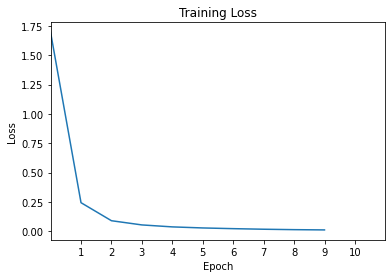

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlim(0, 11)
plt.show()

Implement the same processes to the validation data

In [ ]:
val_texts = X_val.values

input_ids = []
attention_masks = []

for text in val_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(val_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


Predict the validation set

In [ ]:
print('Prediction started on val data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

Prediction started on val data
Prediction completed


In [ ]:
f_score = f1_score(val_labels, prediction_scores, average='macro')
precision = precision_score(val_labels, prediction_scores, average='macro')
recall = recall_score(val_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

report = pd.DataFrame(classification_report(val_labels, prediction_scores, output_dict=True))


print(report)

F-Score:  0.9808482738632499
Recall:  0.9805304822704394
Precision:  0.9814839417716047
                   0     1          2  ...  accuracy     macro avg  weighted avg
precision   0.988235   1.0   1.000000  ...   0.98851      0.981484      0.988632
recall      1.000000   1.0   0.974359  ...   0.98851      0.980530      0.988510
f1-score    0.994083   1.0   0.987013  ...   0.98851      0.980848      0.988497
support    84.000000  74.0  39.000000  ...   0.98851  20453.000000  20453.000000

[4 rows x 180 columns]


Implement the same processes to the submissin (test) dataset and make the predictions

In [ ]:
test_texts = df_test["cleaned_title"].values

In [ ]:
input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#labels = torch.tensor(val_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks)#, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [ ]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch #b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  #label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  #true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []



Prediction started on test data
Prediction completed


In [ ]:
for i in range(len(predictions)):
  pred_labels_it = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_it)

prediction_scores = [item for sublist in prediction_set for item in sublist]

In [ ]:
#df_test["ID"]
submission_df = pd.concat([df_test["ID"], pd.Series(le.inverse_transform(prediction_scores), index=df_test["ID"].index)], axis=1)
submission_df = submission_df.rename(columns={0:"Expected"})
submission_df["Expected"] = submission_df["Expected"].apply(lambda x: int(x.replace("category_", ''))) 
submission_df.to_csv(index=False)

'ID,Expected\n110350,1153150\n90497,1001524\n30915,1000271\n4692,1000037\n95918,1001677\n1251,1000037\n24698,1000271\n73442,1000957\n110570,1165207\n30583,1000271\n81140,1001412\n96607,1001693\n1534,1000037\n69853,1000834\n86155,1001494\n23978,1000271\n11615,1000185\n64920,1000830\n30002,1000271\n417,1000007\n38740,1000271\n65155,1000830\n54334,1000426\n91098,1001527\n6856,1000038\n2478,1000037\n26026,1000271\n29638,1000271\n35659,1000271\n5508,1000037\n89373,1001522\n64536,1000561\n98914,1002510\n92811,1001580\n73051,1000957\n55776,1000452\n89877,1001524\n107381,1106101\n22641,1000264\n2237,1000037\n75484,1000958\n8576,1000180\n51427,1000398\n107587,1106101\n78998,1001399\n73645,1000957\n101089,1002589\n80419,1001410\n84384,1001479\n56250,1000454\n49334,1000380\n56719,1000457\n40807,1000324\n33746,1000271\n9353,1000181\n4510,1000037\n32649,1000271\n25510,1000271\n25751,1000271\n31360,1000271\n73039,1000957\n73026,1000957\n16661,1000208\n51339,1000398\n44862,1000363\n93901,1001660\n770

**Pretrained Model implementation using Description**

Since the description has the title information we try to work on a larger data now.

In [8]:
df_train["cleaned_description"] = df_train["cleaned_description"].apply(lambda x: x.replace("Ürün Detayları ", ""))
df_test["cleaned_description"] = df_test["cleaned_description"].apply(lambda x: x.replace("Ürün Detayları ", ""))
df_train["cleaned_description"][0]

'Sonia SN-X60 Kulak Üstü Oyuncu Kulaklık Konforlu Kulak Yastıkları Konforlu iç yastıklarına sahip olduğu için oldukça uzun süre boyunca rahat bir kullanım yapabilirsiniz. Bu sayede oyun keyfinizi yarıda kesmeden keyfinizi maksimum seviyeye çıkarabilirsiniz. Aynı zamanda kulaklarınızda ağrı yapmaz. Gürültü Önleme Fonksiyonu Gürültü engelleme özelliği ile daha kaliteli bir şekilde görüşme yapmanızı sağlar. Bu sayede karşı taraftan gelen sesi dışardaki gürültülerden arınmış bir şekilde duyabilirsiniz. Aynı zamanda oyun seslerini dışarı yansıtmaz ve etrafı rahatsız etmez. Üstün Ses Deneyimi Mükemmel bas ve tiz ses deneyimi sunar ve daha kaliteli bir şekilde dinleme yapabilirsiniz. Aynı zamanda surround ses efekti ile oyun heyecanınızı maksimum seviyeye çıkarabilirsiniz. Rakiplerinizin sesini net bir şekilde duyarak avantaj sahibi olabilirsiniz. Aydınlatmalı Tasarım RGB LED aydınlatmasına sahip olduğu için oldukça şık bir tasarımı vardır. Oyun esnasında meydana gelen olaylara tepki vererek 

In [9]:
X_train, X_val, y_train, y_val = train_test_split(df_train["cleaned_description"], df_train["CATEGORY_ID"], test_size=0.25, stratify=df_train["CATEGORY_ID"], random_state=42)

In [10]:
training_texts = X_train.values

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

training_labels = y_train
val_labels = y_val



Maximum word length of a title: 15352


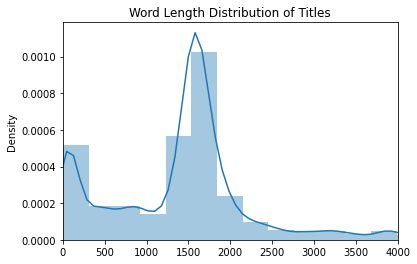

In [11]:
print("Maximum word length of a title:",max(len(x) for x in training_texts))
sns.distplot([len(x) for x in training_texts])
plt.xlim(0, 4000)
plt.title("Word Length Distribution of Titles")
plt.show()

In [18]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=True)
sentences = training_texts
max_len = 128

In [19]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                        truncation = True
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Original:  Windsor WS 3514 S A++ 5 Programlı 12 Kişilik Bulaşık Makinesi Geniş Ailelere Pratik Çözümler Geniş iç hacmi sayesinde oldukça yüksek bir performans sağlayan ürün, her bakımdan kusursuz bir teknolojiye sahiptir. Kullanıcıların beklentilerini tam anlamıyla karşılaması ile bilinen Windsor WS 3514 S A++ 5 Programlı 12 Kişilik Bulaşık Makinesi uzun vadede sizlere oldukça yüksek bir verim sağlayarak, evinizdeki en büyük yardımcınız olacaktır. Çoklu Program Özelliği Sahip olduğu 5 farklı program özelliği ile her zaman sizlere en konforlu bulaşık yıkama keyfini yaşatır. Her bulaşık için farklı bir program kullanabilmenize imkân tanır. Oldukça gelişmiş teknolojisi sayesinde bulaşıklarınızın kirlilik oranına göre temizleme yapabilmektedir. 12 Kişilik Bulaşık Hacmi Geniş ailelerin en önemli tercihlerinden birisi olan Windsor WS 3514 S A++ 5 Programlı 12 Kişilik Bulaşık Makinesi, 12 kişilik hacmi ile sizlere kesintisiz bir performans sağlamaktadır. Bu sayede sizler de alan derdi yaşamad

In [20]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

number_of_categories = len(set(y_train))

model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
    return_dict=False
)

model.cuda()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

In [21]:
epochs = 5

optimizer = AdamW(model.parameters(),
                  lr = 1e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 5 ========
Batch    10  of  3,835.    Elapsed: 0:00:08.
Batch    20  of  3,835.    Elapsed: 0:00:15.
Batch    30  of  3,835.    Elapsed: 0:00:23.
Batch    40  of  3,835.    Elapsed: 0:00:31.
Batch    50  of  3,835.    Elapsed: 0:00:39.
Batch    60  of  3,835.    Elapsed: 0:00:46.
Batch    70  of  3,835.    Elapsed: 0:00:54.
Batch    80  of  3,835.    Elapsed: 0:01:02.
Batch    90  of  3,835.    Elapsed: 0:01:09.
Batch   100  of  3,835.    Elapsed: 0:01:17.
Batch   110  of  3,835.    Elapsed: 0:01:25.
Batch   120  of  3,835.    Elapsed: 0:01:32.
Batch   130  of  3,835.    Elapsed: 0:01:40.
Batch   140  of  3,835.    Elapsed: 0:01:48.
Batch   150  of  3,835.    Elapsed: 0:01:55.
Batch   160  of  3,835.    Elapsed: 0:02:03.
Batch   170  of  3,835.    Elapsed: 0:02:11.
Batch   180  of  3,835.    Elapsed: 0:02:18.
Batch   190  of  3,835.    Elapsed: 0:02:26.
Batch   200  of  3,835.    Elapsed: 0:02:34.
Batch   210  of  3,835.    Elapsed: 0:02:41.
Batch   220  of  3,835.  

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([ 0, 1, 2, 3, 4])
plt.show()

In [ ]:
val_texts = X_val.values

input_ids = []
attention_masks = []

for text in val_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(val_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [ ]:
print('Prediction started on val data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

In [ ]:
f_score = f1_score(val_labels, prediction_scores, average='macro')
precision = precision_score(val_labels, prediction_scores, average='macro')
recall = recall_score(val_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

report = pd.DataFrame(classification_report(val_labels, prediction_scores, output_dict=True))


print(report)

In [ ]:
#Submission

In [ ]:
test_texts = df_test["cleaned_description"].values

In [ ]:
input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#labels = torch.tensor(val_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks)#, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [ ]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch #b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  #label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  #true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []



In [ ]:
for i in range(len(predictions)):
  pred_labels_it = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_it)

prediction_scores = [item for sublist in prediction_set for item in sublist]

In [ ]:
#df_test["ID"]
submission_df = pd.concat([df_test["ID"], pd.Series(le.inverse_transform(prediction_scores), index=df_test["ID"].index)], axis=1)
submission_df = submission_df.rename(columns={0:"Expected"})
submission_df["Expected"] = submission_df["Expected"].apply(lambda x: int(x.replace("category_", ''))) 
submission_df.to_csv(index=False)